In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preparation**

Based on the analysis 03 Module, we use the Excess Rainfall. Next step is importing the previous results.

In [160]:
import zipfile

results_losses = {}
zip_filename = "/content/drive/MyDrive/Colab Notebooks/00 Belajar Machine Learning/05 Anfrek Krukut/Output/results_losses.zip"
with zipfile.ZipFile(zip_filename,"r") as zipf:
  for file in zipf.namelist():
    if file.endswith(".csv"):
      period = file.replace("results_losses_","").replace(".csv","")
      df = pd.read_csv(zipf.open(file))
      results_losses[period]=df

print(f"All files is uploaded completely!")

All files is uploaded completely!


In [161]:
results_losses.keys() # Keys for call the data

dict_keys(['results_losses2', 'results_losses5', 'results_losses10', 'results_losses25', 'results_losses50', 'results_losses100', 'results_losses200', 'results_losses500', 'results_losses1000'])

In [162]:
df_hujan_efektif = pd.DataFrame({key: results_losses[key]["Excess Rainfall"] for key in results_losses.keys()})

df_hujan_efektif

,results_losses2,results_losses5,results_losses10,results_losses25,results_losses50,results_losses100,results_losses200,results_losses500,results_losses1000
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,4.25,6.65,8.73,12.13,15.22,18.78,22.89,29.31,35.13
2,46.41,62.08,75.17,95.49,113.56,134.21,158.04,195.32,228.79
3,13.43,17.50,20.93,26.28,31.01,36.44,42.75,52.58,61.40
4,5.09,6.61,7.83,9.84,11.65,13.65,16.06,19.76,23.07
5,2.55,3.26,3.96,4.97,5.77,6.88,7.98,9.89,11.48
6,71.73,96.10,116.62,148.71,177.21,209.96,247.72,306.86,359.87


# **Create Synthetic Unit Hydrograph<br>**


General Characteristics

In [163]:
# Input Data
river_name = "Krukut"
basin_area = 88.79 # km2
river_length = 37.61 # km (L)
centroid_river_length = 16.827 # Lc
unit_rainfall = 1.00 # mm (Optional) (R)
unit_duration = 1.00 # mm (Optional) (Tr)
endHour = 60.0 + 1 # End of Graph

## Nakayasu Hydrograph

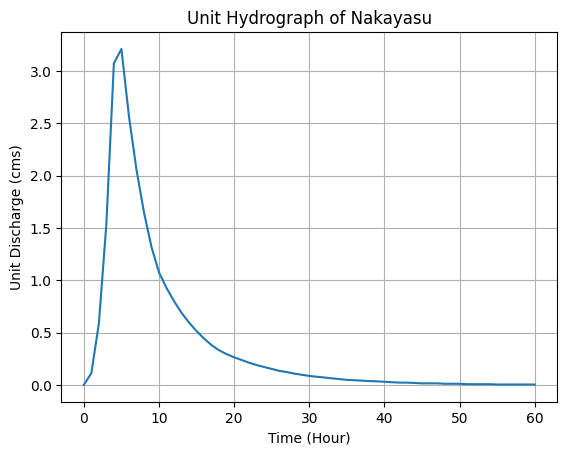

In [164]:
# Parameters of Hydrograph
Name = "Nakayasu"

Ct = 1.0
if river_length < 15:
  Tg = 0.21 * river_length**(0.7)
else:
  Tg = 0.527 + 0.058*river_length
Tr = 0.75 * Tg
T_08 = 0.8 * Tr
Tp = Tg + 0.8 * Tr
a = 2.0 # Time Base (Tb)
initial_third = a * Tg
middle_third = Tp + initial_third
final_third = Tp + initial_third + 1.5*initial_third

# Unit Hydrograph Calculation
Tr_per_Tp = unit_duration / Tp

hss_nakayasu = pd.DataFrame(np.arange(0.0, endHour,1.0), columns=["Time"])
hss_nakayasu["T/Tp"] = (hss_nakayasu["Time"] * Tr_per_Tp).round(3)

hss_nakayasu["qa"] = 0.0
hss_nakayasu.loc[hss_nakayasu["Time"] <= Tp, "qa"] = (hss_nakayasu["T/Tp"]**2.4).round(3)
hss_nakayasu["qd1"] = 0.0
hss_nakayasu.loc[(hss_nakayasu["Time"] > Tp) & (hss_nakayasu["Time"] <= middle_third), "qd1"] = (0.3**((hss_nakayasu["Time"]-Tp)/(initial_third))).round(3)
hss_nakayasu["qd2"] = 0.0
hss_nakayasu.loc[(hss_nakayasu["Time"] > middle_third)&(hss_nakayasu["Time"] <= final_third),"qd2"] = (0.3**((hss_nakayasu["Time"]-Tp+0.5*initial_third)/(1.5*initial_third))).round(3)
hss_nakayasu["qd3"] = 0.0
hss_nakayasu.loc[(hss_nakayasu["Time"] > final_third), "qd3"] = (0.3**((hss_nakayasu["Time"]-Tp+1.5*initial_third)/(2*initial_third))).round(3)
hss_nakayasu["q"] = hss_nakayasu['qa']+hss_nakayasu['qd1']+hss_nakayasu['qd2']+hss_nakayasu['qd3']

area_of_hss = np.sum(hss_nakayasu["q"]) * Tr_per_Tp
Kp = 1/(3.6*area_of_hss)
Qpeak = Kp * basin_area / Tp

hss_nakayasu["Q"] = (hss_nakayasu["q"] * Qpeak).round(3)

plt.plot(hss_nakayasu["Time"],hss_nakayasu["Q"])
plt.xlabel("Time (Hour)")
plt.ylabel("Unit Discharge (cms)")
plt.grid(True)
plt.title(f"Unit Hydrograph of {Name}")
plt.show()

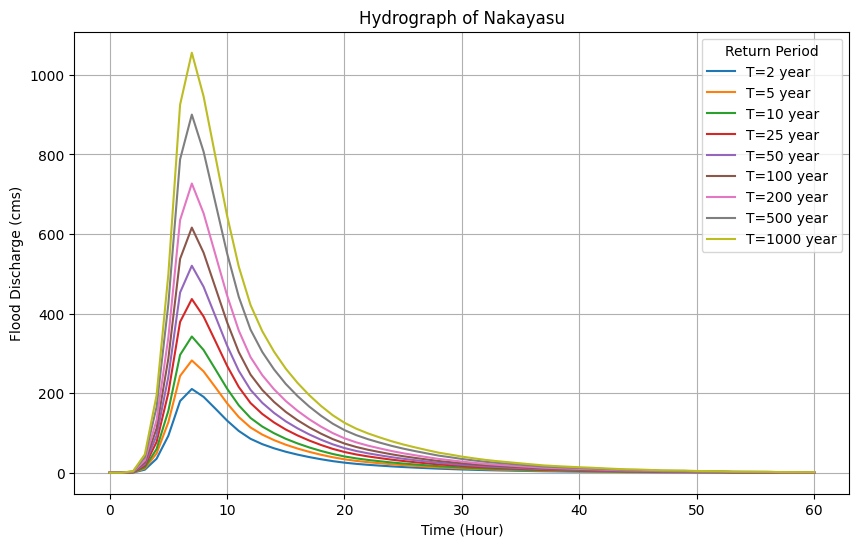

In [165]:
# Hydrograph Superposition
superposisi_nakayasu = hss_nakayasu[['Q']]
bnd = len(df_hujan_efektif)-1
df_hujan_efektif = df_hujan_efektif[:bnd]
rp = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
df_hujan_efektif.columns = rp

hujan_efektif = df_hujan_efektif.values
hss_unit = superposisi_nakayasu["Q"].values

hss_superposisi_nakayasu = pd.DataFrame()

# Superposition Loop
for i, period in enumerate(df_hujan_efektif.columns):
    hss_result = np.convolve(hujan_efektif[:, i], hss_unit)[:len(hss_unit)]
    hss_superposisi_nakayasu[period] = hss_result

# Showing the Graph
plt.figure(figsize=(10, 6))
for column in hss_superposisi_nakayasu.columns:
    plt.plot(hss_superposisi_nakayasu[column], label=f"T={column} year")

plt.xlabel("Time (Hour)")
plt.ylabel("Flood Discharge (cms)")
plt.grid(True)
plt.legend(title="Return Period")
plt.title(f"Hydrograph of {Name}")
plt.show()

In [166]:
hss_superposisi_nakayasu.round(2)

,2,5,10,25,50,100,200,500,1000
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.48,0.74,0.98,1.36,1.70,2.10,2.56,3.28,3.93
3,7.68,10.84,13.53,17.79,21.62,26.02,31.09,39.02,46.18
4,35.19,48.50,59.75,77.46,93.31,111.48,132.45,165.23,194.75
...,...,...,...,...,...,...,...,...,...
56,0.49,0.65,0.79,1.00,1.19,1.41,1.67,2.06,2.41
57,0.35,0.47,0.56,0.72,0.85,1.01,1.19,1.47,1.73
58,0.31,0.41,0.50,0.64,0.76,0.90,1.06,1.32,1.54
59,0.29,0.39,0.48,0.61,0.73,0.86,1.01,1.26,1.47


## Snyder Hydrograph

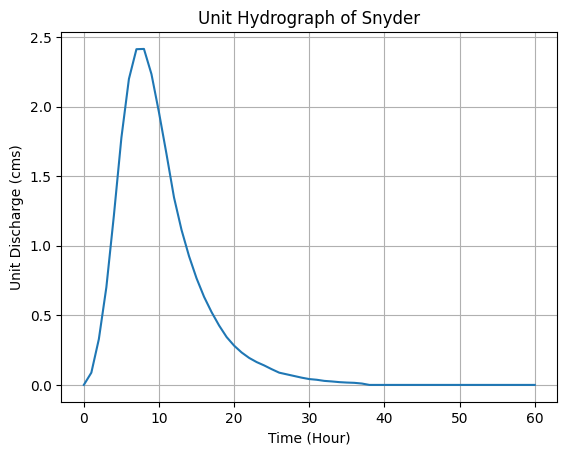

In [167]:
Name = "Snyder"

Ct = 1.0 # Time Coefficient
n = 0.3 # Coefficient Snyder
tp = Ct*(river_length * centroid_river_length)**n # Time Lag
Tp = tp + 0.5 * unit_duration # Time to Peak
Tb = 5 * Tp # Based Time

Tr_per_Tp = unit_duration / Tp

hss_snyder = pd.DataFrame(np.arange(0.0, endHour,1.0), columns=["Time"])
hss_snyder["T/Tp"] = (hss_snyder["Time"] * Tr_per_Tp).round(3)

t_tp = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.5, 4, 4.5, 5])
q_qp = np.array([0, 0.015, 0.075, 0.16, 0.28, 0.43, 0.6, 0.77, 0.89, 0.97, 1, 0.98, 0.92, 0.84, 0.75, 0.66, 0.56, 0.42, 0.32, 0.24, 0.18, 0.13, 0.098, 0.075, 0.036, 0.018, 0.009, 0.004])
ratio = np.array([0.15, 0.6, 0.85, 1.2, 1.5, 1.7, 1.7, 1.2, 0.8, 0.3, -0.2, -0.599999999999999, -0.8, -0.899999999999999, -0.899999999999999, -0.999999999999999, -0.700000000000001, -0.5, -0.4, -0.3, -0.25, -0.16, -0.115, -0.078, -0.036, -0.018, -0.01, 0.0008])

lookup_dict_q = dict(zip(t_tp, q_qp))
lookup_dict_ratio = dict(zip(t_tp, ratio))

hss_snyder['q'] = 0.0
hss_snyder.loc[hss_snyder["T/Tp"] <= 5, "q"] = (np.interp(hss_snyder["T/Tp"], t_tp, q_qp) + np.interp(hss_snyder["T/Tp"], t_tp, ratio) * (hss_snyder["T/Tp"]-np.interp(hss_snyder["T/Tp"], t_tp, t_tp))).round(3)
hss_snyder['Q'] = (hss_snyder['q'] * Qpeak).round(3)

area_of_hss = np.sum(hss_snyder["q"]) * Tr_per_Tp
Kp = 1/(3.6*area_of_hss)
Qpeak = Kp * basin_area / Tp

hss_snyder["Q"] = (hss_snyder["q"] * Qpeak).round(3)

plt.plot(hss_snyder["Time"],hss_snyder["Q"])
plt.xlabel("Time (Hour)")
plt.ylabel("Unit Discharge (cms)")
plt.grid(True)
plt.title(f"Unit Hydrograph of {Name}")
plt.show()

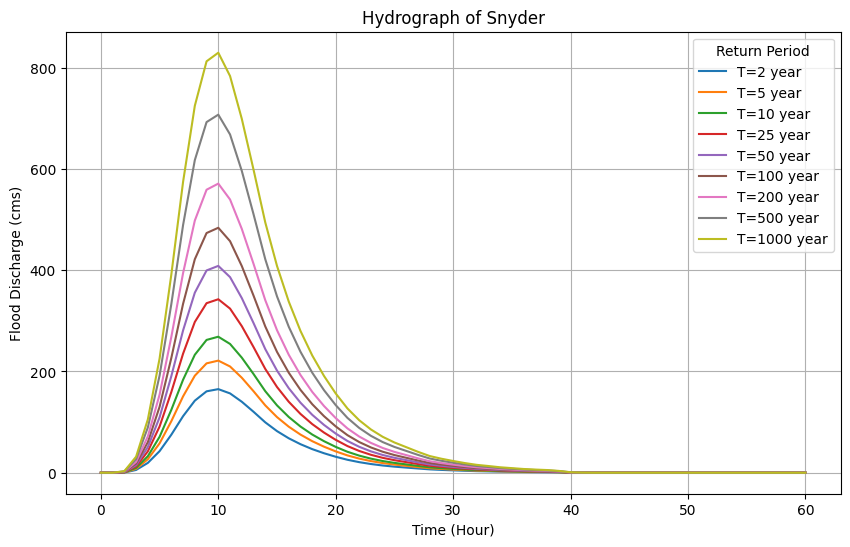

In [168]:
# Hydrograph Superposition
superposisi_snyder = hss_snyder[['Q']]
bnd = len(df_hujan_efektif)-1
df_hujan_efektif = df_hujan_efektif[:bnd]
rp = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
df_hujan_efektif.columns = rp

hujan_efektif = df_hujan_efektif.values
hss_unit = superposisi_snyder["Q"].values

hss_superposisi_snyder = pd.DataFrame()

# Superposition Loop
for i, period in enumerate(df_hujan_efektif.columns):
    hss_result = np.convolve(hujan_efektif[:, i], hss_unit)[:len(hss_unit)]
    hss_superposisi_snyder[period] = hss_result

# Showing the Graph
plt.figure(figsize=(10, 6))
for column in hss_superposisi_snyder.columns:
    plt.plot(hss_superposisi_snyder[column], label=f"T={column} year")

plt.xlabel("Time (Hour)")
plt.ylabel("Flood Discharge (cms)")
plt.grid(True)
plt.legend(title="Return Period")
plt.title(f"Hydrograph of {Name}")
plt.show()

In [169]:
hss_snyder

,Time,T/Tp,q,Q
0,0.0,0.000,0.000,0.000
1,1.0,0.135,0.036,0.088
2,2.0,0.269,0.134,0.329
3,3.0,0.404,0.286,0.702
4,4.0,0.539,0.496,1.217
...,...,...,...,...
56,56.0,7.543,0.000,0.000
57,57.0,7.677,0.000,0.000
58,58.0,7.812,0.000,0.000
59,59.0,7.947,0.000,0.000


# ITB 1

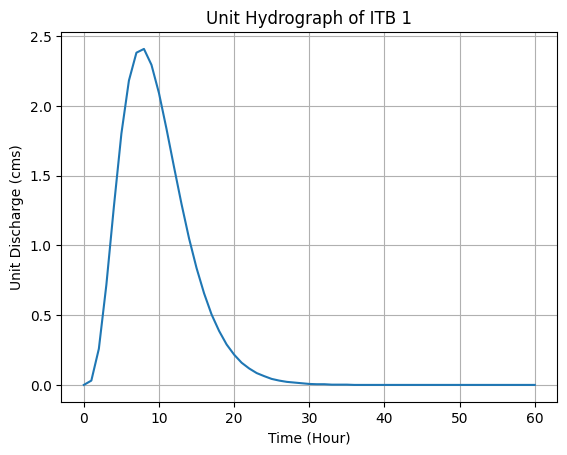

In [170]:
Name = "ITB 1"

Ct = 1
tp = Ct*0.81225*river_length**0.6
Tp = tp + 0.5 * unit_duration
Tb_per_Tp = 6
Tb = Tb_per_Tp * Tp

Tr_per_Tp = unit_duration / Tp
Cp = 1
Alpha = 3.7

hss_itb1 = pd.DataFrame(np.arange(0.0, endHour,1.0), columns=["Time"])
hss_itb1["T/Tp"] = (hss_itb1["Time"] * Tr_per_Tp).round(3)
hss_itb1["q"] = ((hss_itb1["T/Tp"] * np.exp(1-hss_itb1["T/Tp"]))**(Alpha*Cp)).round(3)

Ahss = np.sum(hss_itb1["q"]) * Tr_per_Tp
Kp = 1/(3.6*Ahss)
Qpeak = Kp * basin_area / Tp

hss_itb1["Q"] = (Qpeak * hss_itb1["q"]).round(3)

plt.plot(hss_itb1["Time"],hss_itb1["Q"])
plt.xlabel("Time (Hour)")
plt.ylabel("Unit Discharge (cms)")
plt.grid(True)
plt.title(f"Unit Hydrograph of {Name}")
plt.show()

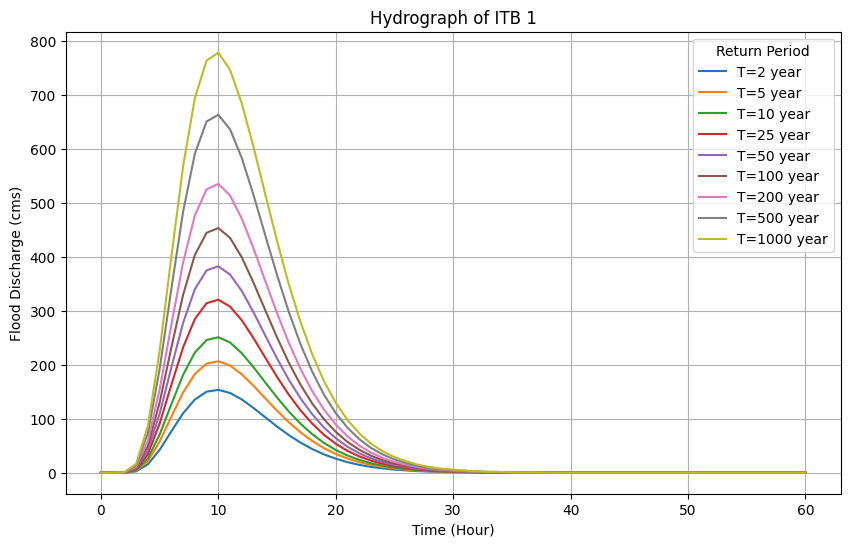

In [171]:
# Hydrograph Superposition
superposisi_itb1 = hss_itb1[['Q']]
bnd = len(df_hujan_efektif)-1
df_hujan_efektif = df_hujan_efektif[:bnd]
rp = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
df_hujan_efektif.columns = rp

hujan_efektif = df_hujan_efektif.values
hss_unit = superposisi_itb1["Q"].values

hss_superposisi_itb1 = pd.DataFrame()

# Superposition Loop
for i, period in enumerate(df_hujan_efektif.columns):
    hss_result = np.convolve(hujan_efektif[:, i], hss_unit)[:len(hss_unit)]
    hss_superposisi_itb1[period] = hss_result

# Showing the Graph
plt.figure(figsize=(10, 6))
for column in hss_superposisi_itb1.columns:
    plt.plot(hss_superposisi_itb1[column], label=f"T={column} year")

plt.xlabel("Time (Hour)")
plt.ylabel("Flood Discharge (cms)")
plt.grid(True)
plt.legend(title="Return Period")
plt.title(f"Hydrograph of {Name}")
plt.show()

# ITB 2

In [172]:
Name = "ITB 2"

Ct = 1
tp = Ct * (0.0394 * river_length + 0.201 * river_length**0.5)
Tp = 1.6 * tp
Tb_per_Tp = 20
Tb = Tb_per_Tp * Tp

Tr_per_Tp = unit_duration / Tp
Cp = 1
alpha = 2.4
beta = 0.8

hss_itb2 = pd.DataFrame(np.arange(0.0, endHour,1.0), columns=["Time"])
hss_itb2["T/Tp"] = (hss_itb2["Time"] * Tr_per_Tp).round(3)

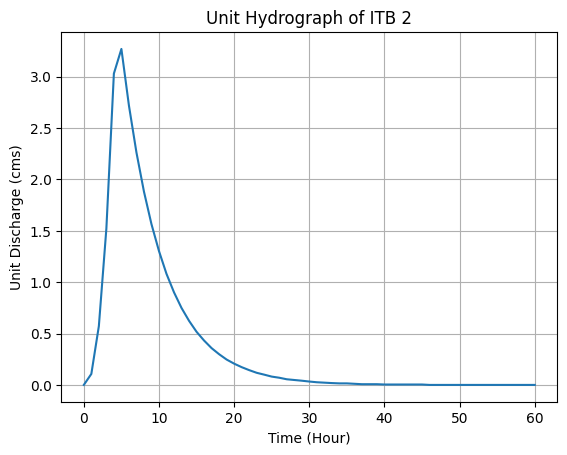

In [173]:
hss_itb2["q1"] = 0.0
hss_itb2.loc[(hss_itb2["T/Tp"] <= 1), "q1"] = hss_itb2["T/Tp"]**alpha
hss_itb2["q2"] = 0.0
hss_itb2.loc[(hss_itb2["T/Tp"] > 1) & (hss_itb2["T/Tp"] <= Tb_per_Tp), "q2"] = np.exp(((1-hss_itb2["T/Tp"])*(beta*Cp)))

hss_itb2["q"] = (hss_itb2["q1"] + hss_itb2["q2"]).round(3)

Ahss = np.sum(hss_itb2["q"]) * Tr_per_Tp
Kp = 1 / (3.6 * Ahss)
Qpeak = Kp * basin_area / Tp

hss_itb2["Q"] = (Qpeak * hss_itb2["q"]).round(3)

plt.plot(hss_itb2["Time"],hss_itb2["Q"])
plt.xlabel("Time (Hour)")
plt.ylabel("Unit Discharge (cms)")
plt.grid(True)
plt.title(f"Unit Hydrograph of {Name}")
plt.show()

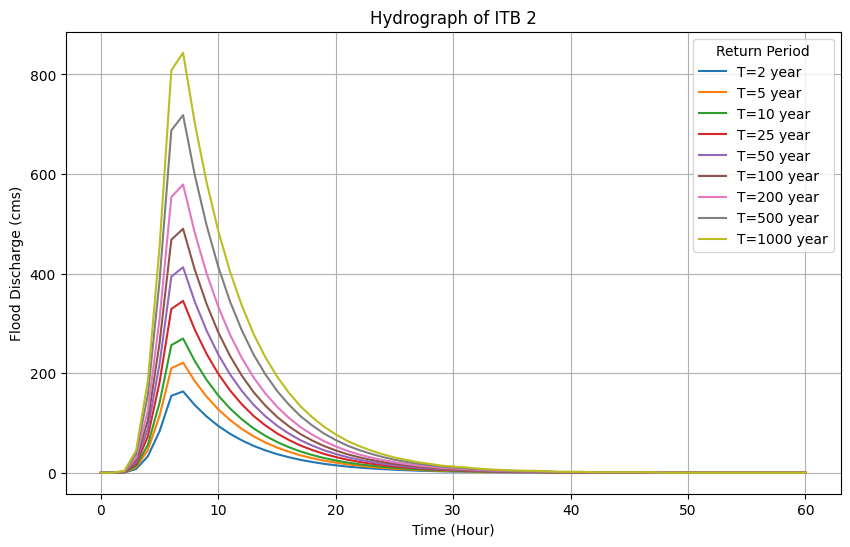

In [174]:
# Hydrograph Superposition
superposisi_itb2 = hss_itb2[['Q']]
bnd = len(df_hujan_efektif)-1
df_hujan_efektif = df_hujan_efektif[:bnd]
rp = [2, 5, 10, 25, 50, 100, 200, 500, 1000]
df_hujan_efektif.columns = rp

hujan_efektif = df_hujan_efektif.values
hss_unit = superposisi_itb2["Q"].values

hss_superposisi_itb2 = pd.DataFrame()

# Superposition Loop
for i, period in enumerate(df_hujan_efektif.columns):
    hss_result = np.convolve(hujan_efektif[:, i], hss_unit)[:len(hss_unit)]
    hss_superposisi_itb2[period] = hss_result

# Showing the Graph
plt.figure(figsize=(10, 6))
for column in hss_superposisi_itb2.columns:
    plt.plot(hss_superposisi_itb2[column], label=f"T={column} year")

plt.xlabel("Time (Hour)")
plt.ylabel("Flood Discharge (cms)")
plt.grid(True)
plt.legend(title="Return Period")
plt.title(f"Hydrograph of {Name}")
plt.show()

# Credits
<a href="https://www.linkedin.com/in/iqbalfauzanh/"><img src="https://img.shields.io/badge/-© 2025 Iqbal Fauzan Herlambang-417DAC?style=for-the-badge&logoColor=white"/></a>